# Input

In [1]:
import h5py

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as signal
import pywt

import wfdb
import os

from biosppy import storage
from biosppy.signals import ecg

from sklearn.metrics import mean_absolute_error

# PQRST window detection

In [2]:
def r_peaks_detection(signal, sampling_rate=250.):
  out = ecg.ecg(signal=signal, sampling_rate=sampling_rate, show=False)
  return out["rpeaks"]

In [3]:
def qs_peaks_detection(signal, r_peaks, qs_range=20):
  qs_peaks = []
  for r_peak in r_peaks:
    if r_peak - qs_range >= 0:
      q_signal_slice = signal[r_peak - qs_range: r_peak]
      q_peak = np.argmin(q_signal_slice, axis=0) + r_peak - qs_range
      qs_peaks.append(q_peak)
    if r_peak + qs_range <= len(signal):
      s_signal_slice = signal[r_peak: r_peak + qs_range]
      s_peak = np.argmin(s_signal_slice, axis=0) + r_peak
      qs_peaks.append(s_peak)
  return qs_peaks

In [4]:
def pt_peaks_detection(signal, r_peaks, alpha=0, beta=0, coef=1):
  p_min = -20
  p_max = (-40 - beta) * coef
  t_min = 20
  t_max = (50 + alpha) * coef # or do not do +1 -- to try
  pt_peaks = []
  for r_peak in r_peaks:
    if r_peak + p_max >= 0:
      p_signal_slice = signal[int(r_peak + p_max):int(r_peak + p_min)]
      p_peak = np.argmax(p_signal_slice, axis=0) + r_peak + p_max
      pt_peaks.append(p_peak)
    if r_peak + t_max <= len(signal):
      t_signal_slice = signal[int(r_peak+t_min):int(r_peak+t_max)]
      t_peak = np.argmax(t_signal_slice, axis=0) + r_peak + t_min
      pt_peaks.append(t_peak)
  return pt_peaks

In [5]:
def pqrst_detection(signal, qs_drop=False, r_drop=False, alpha=0, beta=0, coef=1):
  peaks = []
  r_peaks = r_peaks_detection(signal)
  if not qs_drop:
    peaks.extend(qs_peaks_detection(signal, r_peaks))
  if not r_drop:
    peaks.extend(r_peaks)
  peaks.extend(pt_peaks_detection(signal, r_peaks, alpha=alpha, beta=beta, coef=coef))
  return sorted(peaks)

# Dataset cleaning

In [6]:
def del_duplic(symbols, samples):
  clean_symbols = []
  clean_samples = []
  index = 0
  while index < len(symbols) - 1:
    if symbols[index] != symbols[index+1]:
      clean_symbols.append(symbols[index])
      clean_samples.append(samples[index])
    index+=1
  clean_symbols.append(symbols[len(symbols)-1])
  clean_samples.append(len(symbols)-1)
  return clean_symbols, clean_samples

In [7]:
def clear_rng(clean_samples, clean_symbols):
  true_peaks = []
  true_symbols = []

  for index, (peak_index, peak) in enumerate(zip(clean_samples, clean_symbols)):
    if peak != "(" and peak != ")":
      true_peaks.append(peak_index)
      true_symbols.append(peak)
  return true_peaks, true_symbols

In [8]:
def pnt_seq(true_peaks, true_symbols):
  indexes = []
  i = 1
  while i <= len(true_symbols)-2:
    if true_symbols[i] == "N":
      if true_symbols[i-1] == "p" and true_symbols[i+1] == "t":
        indexes.append(i-1)
        indexes.append(i)
        indexes.append(i+1)
    i+=1
  peaks = [true_peaks[i] for i in indexes]
  symbols = [true_symbols[i] for i in indexes]
  return peaks, symbols

In [9]:
def dataset_prep(symbol, sample):
  symbols = symbol
  samples = sample
  clean_symbols, clean_samples = del_duplic(symbols, samples)
  true_peaks, true_symbols = clear_rng(clean_samples, clean_symbols)
  peaks, symbols = pnt_seq(true_peaks,true_symbols)
  return peaks, symbols

In [10]:
def sync_peaks(prt_peaks, peaks):
  window_ind = []
  ind = []
  find_j = -2

  for i in range(1, len(peaks),3):
    find = False
    j = find_j + 3
    while not find and j <= len(prt_peaks)-2:
      if abs(peaks[i] - prt_peaks[j]) < 20:
        window_ind += [prt_peaks[j-1], prt_peaks[j], prt_peaks[j+1]]
        ind += [peaks[i-1], peaks[i], peaks[i+1]]
        find_j = j
        find = True
      else:
        j += 3
  # peaks = ind
  # window_peaks = window_ind
  drops = len(peaks) - len(ind)
  if drops > 0:
    print(f"When syncing missed values was found: {drops} ({drops*100/len(peaks)}%)")
  return ind, window_ind

# Comparing manual and auto detection from dataset

In [11]:
input_directory = '/content/physionet.org/files/qtdb/1.0.0/'
input_files = []
for f in os.listdir(input_directory):
    if os.path.isfile(os.path.join(input_directory, f)) and not f.lower().startswith(".") and f.lower().endswith("q1c"):
        input_files.append(f[:-4])
num_files = len(input_files)

data_filepath = 'D:/Test Jupyter/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/ptbxl/'

X = np.load(data_filepath + 'raw100.npy', allow_pickle=True)

In [ ]:
peaks_p_all = []
peaks_n_all = []
peaks_t_all = []

peaks_p_auto_all = []
peaks_n_auto_all = []
peaks_t_auto_all = []

true_peaks_all = []
true_peaks_all_auto = []

for temp_file_index, temp_file in enumerate(input_files):

  temp_file_path = os.path.join(input_directory, temp_file)
  record_atr = wfdb.rdann(temp_file_path, 'q1c')
  record_atr_auto = wfdb.rdann(temp_file_path, 'pu0')
  record = wfdb.rdrecord(temp_file_path, channels=[0])

  true_peaks, true_symbols = dataset_prep(record_atr.symbol, record_atr.sample)
  true_peaks_auto, true_symbols_auto = dataset_prep(record_atr_auto.symbol, record_atr_auto.sample)

  true_p, true_p_auto = sync_peaks(true_peaks_auto, true_peaks)

  true_peaks_all.extend(true_p)
  true_peaks_all_auto.extend(true_p_auto)

  peaks_p = [val for i,val in enumerate(true_p) if i%3 == 0]
  peaks_n = [val for i,val in enumerate(true_p) if (i-1)%3 == 0]
  peaks_t = [val for i,val in enumerate(true_p) if (i-2)%3 == 0]

  peaks_p_auto = [val for i,val in enumerate(true_p_auto) if i%3 == 0]
  peaks_n_auto = [val for i,val in enumerate(true_p_auto) if (i-1)%3 == 0]
  peaks_t_auto = [val for i,val in enumerate(true_p_auto) if (i-2)%3 == 0]

  peaks_p_all.extend(peaks_p)
  peaks_n_all.extend(peaks_n)
  peaks_t_all.extend(peaks_t)

  peaks_p_auto_all.extend(peaks_p_auto)
  peaks_n_auto_all.extend(peaks_n_auto)
  peaks_t_auto_all.extend(peaks_t_auto)

When syncing missed values was found: 6 (4.0%)
When syncing missed values was found: 3 (3.3333333333333335%)
When syncing missed values was found: 48 (55.172413793103445%)
When syncing missed values was found: 90 (100.0%)
When syncing missed values was found: 9 (6.0%)
When syncing missed values was found: 45 (50.0%)
When syncing missed values was found: 3 (1.408450704225352%)
When syncing missed values was found: 54 (60.0%)
When syncing missed values was found: 3 (3.3333333333333335%)
When syncing missed values was found: 60 (66.66666666666667%)
When syncing missed values was found: 3 (3.3333333333333335%)
When syncing missed values was found: 3 (3.3333333333333335%)
When syncing missed values was found: 18 (21.428571428571427%)
When syncing missed values was found: 12 (18.181818181818183%)
When syncing missed values was found: 6 (11.764705882352942%)
When syncing missed values was found: 9 (10.0%)
When syncing missed values was found: 3 (3.3333333333333335%)
When syncing missed values

In [ ]:
print(f"MAE score for dataset's automatically determined waveform boundary measurements:  {mean_absolute_error(true_peaks_all, true_peaks_all_auto)}")
print(f"MAE score for dataset's automatically determined waveform boundary measurements p peaks:  {mean_absolute_error(peaks_p_all, peaks_p_auto_all)}")
print(f"MAE score for dataset's automatically determined waveform boundary measurements r peaks:  {mean_absolute_error(peaks_n_all, peaks_n_auto_all)}")
print(f"MAE score for dataset's automatically determined waveform boundary measurements t peaks:  {mean_absolute_error(peaks_t_all, peaks_t_auto_all)}")

MAE score for dataset's automatically determined waveform boundary measurements:  5.379580220562078
MAE score for dataset's automatically determined waveform boundary measurements p peaks:  3.4368552116684454
MAE score for dataset's automatically determined waveform boundary measurements r peaks:  2.8616150836001424
MAE score for dataset's automatically determined waveform boundary measurements t peaks:  9.840270366417645


In [ ]:
print(f"MAE score for dataset's automatically determined waveform boundary measurements p peaks:  {mean_absolute_error(peaks_p_all, peaks_p_auto_all)}")
print(f"MAE score for dataset's automatically determined waveform boundary measurements t peaks:  {mean_absolute_error(peaks_t_all, peaks_t_auto_all)}")

p = 0
for p_, p_pred in zip(peaks_p_all, peaks_p_auto_all):
 if abs(p_ - p_pred) <= 5:
   p+=1
print("Accuracy for dataset's automatically determined waveform boundary measurements p peaks: ",int((p * 100)/len(peaks_p_all)) ,"%")

t = 0
for t_, t_pred in zip(peaks_t_all, peaks_t_auto_all):
 if abs(t_ - t_pred) <= 5:
   t+=1
print("Accuracy for dataset's automatically determined waveform boundary measurements t peaks: ",int((t * 100)/len(peaks_t_all)) ,"%")


MAE score for dataset's automatically determined waveform boundary measurements p peaks:  3.4368552116684454
MAE score for dataset's automatically determined waveform boundary measurements t peaks:  9.840270366417645
Accuracy for dataset's automatically determined waveform boundary measurements p peaks:  84 %
Accuracy for dataset's automatically determined waveform boundary measurements t peaks:  68 %


# Comparing manual and my detection

In [ ]:
peaks_p_all = []
peaks_n_all = []
peaks_t_all = []

peaks_p_window_all = []
peaks_n_window_all = []
peaks_t_window_all = []

true_peaks_all = []
true_peaks_all_window = []
for temp_file_index, temp_file in enumerate(input_files):

  temp_file_path = os.path.join(input_directory, temp_file)
  record_atr = wfdb.rdann(temp_file_path, 'q1c')

  record = wfdb.rdrecord(temp_file_path, channels=[0])

  true_peaks, true_symbols = dataset_prep(record_atr.symbol, record_atr.sample)
  l_range = 0
  r_range = len(record.p_signal)+1

  data_slice = np.ndarray.flatten(record.p_signal[l_range:r_range])
  peaks = pqrst_detection(data_slice,qs_drop=True, alpha=0)

  true_p, true_p_wind = sync_peaks(peaks, true_peaks)
  true_peaks_all.extend(true_p)
  true_peaks_all_window.extend(true_p_wind)

  peaks_p = [val for i,val in enumerate(true_p) if i%3 == 0]
  peaks_p_all.extend(peaks_p)
  peaks_n = [val for i,val in enumerate(true_p) if (i-1)%3 == 0]
  peaks_n_all.extend(peaks_n)
  peaks_t = [val for i,val in enumerate(true_p) if (i-2)%3 == 0]
  peaks_t_all.extend(peaks_t)

  peaks_p_wind = [val for i,val in enumerate(true_p_wind) if i%3 == 0]
  peaks_p_window_all.extend(peaks_p_wind)
  peaks_n_wind = [val for i,val in enumerate(true_p_wind) if (i-1)%3 == 0]
  peaks_n_window_all.extend(peaks_n_wind)
  peaks_t_wind = [val for i,val in enumerate(true_p_wind) if (i-2)%3 == 0]
  peaks_t_window_all.extend(peaks_t_wind)

When syncing missed values was found: 3 (2.0%)


In [ ]:
print(f"MAE score for window algorithm p peaks:  {mean_absolute_error(peaks_p_all, peaks_p_window_all)}")
print(f"MAE score for window algorithm t peaks:  {mean_absolute_error(peaks_t_all, peaks_t_window_all)}")

MAE score for window algorithm p peaks:  7.692982456140351
MAE score for window algorithm t peaks:  28.594611528822057


In [ ]:
print(f"MAE score for window algorithm p peaks:  {mean_absolute_error(peaks_p_all, peaks_p_window_all)}")
print(f"MAE score for window algorithm t peaks:  {mean_absolute_error(peaks_t_all, peaks_t_window_all)}")

p = 0
for p_, p_pred in zip(peaks_p_all, peaks_p_window_all):
 if abs(p_ - p_pred) <= 5:
   p+=1
print("Accuracy for window algorithm p peaks: ",int((p * 100)/len(peaks_p_all)) ,"%")

t = 0
for t_, t_pred in zip(peaks_t_all, peaks_t_window_all):
 if abs(t_ - t_pred) <= 5:
   t+=1
print("Accuracy for window algorithm t peaks: ",int((t * 100)/len(peaks_t_all)) ,"%")

MAE score for window algorithm p peaks:  7.692982456140351
MAE score for window algorithm t peaks:  28.594611528822057
Accuracy for window algorithm p peaks:  60 %
Accuracy for window algorithm t peaks:  5 %


# Finding best apha/beta

In [ ]:
alpha_list = np.arange(-5,40,0.5)
beta_list = np.arange(-15,50,0.5)

peaks_p_all = []
peaks_n_all = []
peaks_t_all = []

peaks_p_window_ab_all = []
peaks_n_window_ab_all = []
peaks_t_window_ab_all = []

true_peaks_all = []
true_peaks_all_window_ab = []

for temp_file_index, temp_file in enumerate(input_files):

  temp_file_path = os.path.join(input_directory, temp_file)
  record_atr = wfdb.rdann(temp_file_path, 'q1c')

  record = wfdb.rdrecord(temp_file_path, channels=[0])

  true_peaks, true_symbols = dataset_prep(record_atr.symbol, record_atr.sample)

  mae_t = []
  if len(true_peaks) > 3:
    l_range = 0
    r_range = len(record.p_signal)+1

    data_slice = np.ndarray.flatten(record.p_signal[l_range:r_range])
    for index, alpha in enumerate(alpha_list):
      true_peaks, true_symbols = dataset_prep(record_atr.symbol, record_atr.sample)
      peaks = pqrst_detection(data_slice,qs_drop=True, alpha=alpha)
      true_peaks, peaks = sync_peaks(peaks, true_peaks)
      peaks_t = [val for i,val in enumerate(true_peaks) if (i-2)%3 == 0]

      window_peaks_t = [val for i,val in enumerate(peaks) if (i-2)%3 == 0]

      mae_t.append(mean_absolute_error(peaks_t, window_peaks_t))

    alpha = alpha_list[np.argmin(mae_t)]

    mae_p = []

    true_peaks, true_symbols = dataset_prep(record_atr.symbol, record_atr.sample)

    for index, beta in enumerate(beta_list):
      peaks = pqrst_detection(data_slice,qs_drop=True, beta=beta )
      true_peaks, peaks = sync_peaks(peaks, true_peaks)

      peaks_p = [val for i,val in enumerate(true_peaks) if i%3 == 0]

      window_peaks_p = [val for i,val in enumerate(peaks) if i%3 == 0]
      if len(window_peaks_p) > 1:
        mae_p.append(mean_absolute_error(peaks_p, window_peaks_p))

    beta = beta_list[np.argmin(mae_p)]

    l_range = 0
    r_range = len(record.p_signal)+1

    data_slice = np.ndarray.flatten(record.p_signal[l_range:r_range])
    peaks = pqrst_detection(data_slice,qs_drop=True, alpha=alpha, beta=beta)

    true_peaks, true_symbols = dataset_prep(record_atr.symbol, record_atr.sample)

    true_peaks, peaks = sync_peaks(peaks, true_peaks)
    true_peaks_all.extend(true_p)
    true_peaks_all_window.extend(true_p_wind)

    peaks_p = [val for i,val in enumerate(true_peaks) if i%3 == 0]
    peaks_p_all.extend(peaks_p)
    peaks_n = [val for i,val in enumerate(true_peaks) if (i-1)%3 == 0]
    peaks_n_all.extend(peaks_n)
    peaks_t = [val for i,val in enumerate(true_peaks) if (i-2)%3 == 0]
    peaks_t_all.extend(peaks_t)

    window_peaks_p = [val for i,val in enumerate(peaks) if i%3 == 0]
    peaks_p_window_ab_all.extend(window_peaks_p)
    window_peaks_n = [val for i,val in enumerate(peaks) if (i-1)%3 == 0]
    peaks_n_window_ab_all.extend(window_peaks_n)
    window_peaks_t = [val for i,val in enumerate(peaks) if (i-2)%3 == 0]
    peaks_t_window_ab_all.extend(window_peaks_t)

When syncing missed values was found: 90 (100.0%)
When syncing missed values was found: 90 (100.0%)
When syncing missed values was found: 90 (100.0%)
When syncing missed values was found: 198 (92.95774647887323%)
When syncing missed values was found: 90 (100.0%)
When syncing missed values was found: 30 (35.714285714285715%)
When syncing missed values was found: 15 (22.727272727272727%)
When syncing missed values was found: 75 (83.33333333333333%)
When syncing missed values was found: 75 (83.33333333333333%)
When syncing missed values was found: 90 (100.0%)
When syncing missed values was found: 171 (98.27586206896552%)
When syncing missed values was found: 3 (2.0%)
When syncing missed values was found: 3 (2.0%)
When syncing missed values was found: 3 (2.0%)
When syncing missed values was found: 3 (2.0%)
When syncing missed values was found: 3 (2.0%)
When syncing missed values was found: 3 (2.0%)
When syncing missed values was found: 3 (2.0%)
When syncing missed values was found: 3 (2.0%

In [ ]:
print(f"MAE score for window method with best alpha/beta p peaks:  {mean_absolute_error(peaks_p_all, peaks_p_window_ab_all)}")
print(f"MAE score for window method with best alpha/beta t peaks:  {mean_absolute_error(peaks_t_all, peaks_t_window_ab_all)}")

p = 0
for p_, p_pred in zip(peaks_p_all, peaks_p_window_ab_all):
 if abs(p_ - p_pred) <= 5:
   p+=1
print("Accuracy for window method with best alpha/beta p peaks: ",int((p * 100)/len(peaks_p_all)) ,"%")

t = 0
for t_, t_pred in zip(peaks_t_all, peaks_t_window_ab_all):
 if abs(t_ - t_pred) <= 5:
   t+=1
print("Accuracy for window method with best alpha/beta t peaks: ",int((t * 100)/len(peaks_t_all)) ,"%")

MAE score for window method with best alpha/beta p peaks:  3.6259398496240602
MAE score for window method with best alpha/beta t peaks:  8.166353383458647
Accuracy for window method with best alpha/beta p peaks:  85 %
Accuracy for window method with best alpha/beta t peaks:  69 %


# Adaptive alpha/beta

In [ ]:
def rr_pt_detection(signal, alpha=0, beta=0, coef=1):
  pt_peaks = []
  out = ecg.ecg(signal=signal, sampling_rate=250., show=False)
  hr = out["heart_rate"]
  mean_hr = np.mean(hr)
  r_peaks = out["rpeaks"]
  for i in range(len(hr)-1):
    coef = hr[i] / mean_hr
    p_min = -20
    p_max = int((-40 - beta) * coef)
    t_min = 20
    t_max = int((50 + alpha) * coef)

    if i == 0 and r_peaks[i] + p_max >= 0 :
      p_min = -20
      p_max = (-40 - beta)
      t_min = 20
      t_max = (50 + alpha)
      p_signal_slice = signal[int(r_peaks[i] + p_max):int(r_peaks[i] + p_min)]
      p_peak = np.argmax(p_signal_slice, axis=0) + r_peaks[i] + p_max
      pt_peaks.append(int(p_peak))

    p_signal_slice = signal[int(r_peaks[i+1] + p_max):int(r_peaks[i+1] + p_min)]
    if len(p_signal_slice) > 1:
      p_peak = np.argmax(p_signal_slice, axis=0) + r_peaks[i+1] + p_max
      pt_peaks.append(int(p_peak))
    t_signal_slice = signal[int(r_peaks[i]+t_min):int(r_peaks[i]+t_max)]
    if len(t_signal_slice) > 1:
      t_peak = np.argmax(t_signal_slice, axis=0) + r_peaks[i] + t_min
      pt_peaks.append(int(t_peak))

  p_min = -20
  p_max = (-40 - beta)
  t_min = 20
  t_max = (50 + alpha)
  if r_peaks[len(r_peaks)-1] + t_max <= len(signal):
    t_signal_slice = signal[int(r_peaks[len(r_peaks)-1]+t_min):int(r_peaks[len(r_peaks)-1]+t_max)]
    t_peak = np.argmax(t_signal_slice, axis=0) + r_peaks[len(r_peaks)-1] + t_min
    pt_peaks.append(t_peak)

  pt_peaks.extend(list(r_peaks))
  return sorted(pt_peaks)

In [ ]:
alpha_list = np.arange(-5,40,1)
beta_list = np.arange(-15,50,1)

peaks_p_all = []
peaks_n_all = []
peaks_t_all = []

peaks_p_window_ab_adapt_all = []
peaks_n_window_ab_adapt_all = []
peaks_t_window_ab_adapt_all = []

true_peaks_all = []
true_peaks_all_window_ab_adapt = []

for temp_file_index, temp_file in enumerate(input_files):
  print(temp_file_index,"/", len(input_files))
  temp_file_path = os.path.join(input_directory, temp_file)
  record_atr = wfdb.rdann(temp_file_path, 'q1c')

  record = wfdb.rdrecord(temp_file_path, channels=[0])

  true_peaks, true_symbols = dataset_prep(record_atr.symbol, record_atr.sample)

  mae_t = []

  if len(true_peaks) > 3:
    l_range = 0
    r_range = len(record.p_signal)+1

    data_slice = np.ndarray.flatten(record.p_signal[l_range:r_range])
    for index, alpha in enumerate(alpha_list):
      true_peaks, true_symbols = dataset_prep(record_atr.symbol, record_atr.sample)
      peaks = pqrst_detection(data_slice,qs_drop=True, alpha=alpha)
      true_peaks, peaks = sync_peaks(peaks, true_peaks)
      peaks_t = [val for i,val in enumerate(true_peaks) if (i-2)%3 == 0]

      window_peaks_t = [val for i,val in enumerate(peaks) if (i-2)%3 == 0]
      if len(window_peaks_t) > 1:
        mae_t.append(mean_absolute_error(peaks_t, window_peaks_t))
      else: mae_t.append(9999999)

    alpha = alpha_list[np.argmin(mae_t)]

    mae_p = []

    true_peaks, true_symbols = dataset_prep(record_atr.symbol, record_atr.sample)

    for index, beta in enumerate(beta_list):
      peaks = pqrst_detection(data_slice,qs_drop=True, beta=beta )
      true_peaks, peaks = sync_peaks(peaks, true_peaks)

      peaks_p = [val for i,val in enumerate(true_peaks) if i%3 == 0]

      window_peaks_p = [val for i,val in enumerate(peaks) if i%3 == 0]
      if len(window_peaks_p) >  1:
        mae_p.append(mean_absolute_error(peaks_p, window_peaks_p))
      else:
        mae_p.append(9999999)

    beta = beta_list[np.argmin(mae_p)]

    l_range = 0
    r_range = len(record.p_signal)+1

    data_slice = np.ndarray.flatten(record.p_signal[l_range:r_range])
    prt_peaks = rr_pt_detection(data_slice, alpha=alpha, beta=beta)

    true_peaks, true_symbols = dataset_prep(record_atr.symbol, record_atr.sample)

    true_peaks, peaks = sync_peaks(prt_peaks, true_peaks)

    peaks_p = [val for i,val in enumerate(true_peaks) if i%3 == 0]
    peaks_p_all.extend(peaks_p)
    peaks_n = [val for i,val in enumerate(true_peaks) if (i-1)%3 == 0]
    peaks_n_all.extend(peaks_n)
    peaks_t = [val for i,val in enumerate(true_peaks) if (i-2)%3 == 0]
    peaks_t_all.extend(peaks_t)

    window_peaks_p = [val for i,val in enumerate(peaks) if i%3 == 0]
    peaks_p_window_ab_adapt_all.extend(window_peaks_p)
    window_peaks_n = [val for i,val in enumerate(peaks) if (i-1)%3 == 0]
    peaks_n_window_ab_adapt_all.extend(window_peaks_n)
    window_peaks_t = [val for i,val in enumerate(peaks) if (i-2)%3 == 0]
    peaks_t_window_ab_adapt_all.extend(window_peaks_t)

0 / 105
1 / 105
When syncing missed values was found: 90 (100.0%)
2 / 105
When syncing missed values was found: 150 (100.0%)
When syncing missed values was found: 99 (66.0%)
3 / 105
4 / 105
5 / 105
6 / 105
When syncing missed values was found: 90 (96.7741935483871%)
7 / 105
8 / 105
9 / 105
When syncing missed values was found: 60 (66.66666666666667%)
10 / 105
11 / 105
12 / 105
13 / 105
14 / 105
15 / 105
16 / 105
17 / 105
When syncing missed values was found: 90 (100.0%)
18 / 105
When syncing missed values was found: 60 (66.66666666666667%)
19 / 105
20 / 105
21 / 105
When syncing missed values was found: 171 (98.27586206896552%)
When syncing missed values was found: 174 (100.0%)
22 / 105
23 / 105
When syncing missed values was found: 75 (83.33333333333333%)
When syncing missed values was found: 60 (66.66666666666667%)
24 / 105
25 / 105
26 / 105
When syncing missed values was found: 15 (22.727272727272727%)
27 / 105
28 / 105
When syncing missed values was found: 90 (100.0%)
29 / 105
When

In [ ]:
# print(f"MAE score for window method with a/b and coef:  {mean_absolute_error(true_peaks_all, true_peaks_all_window_ab_adapt)}")
print(f"MAE score for window method with a/b and coef p peaks:  {mean_absolute_error(peaks_p_all, peaks_p_window_ab_adapt_all)}")
print(f"MAE score for window method with a/b and coef r peaks:  {mean_absolute_error(peaks_n_all, peaks_n_window_ab_adapt_all)}")
print(f"MAE score for window method with a/b and coef t peaks:  {mean_absolute_error(peaks_t_all, peaks_t_window_ab_adapt_all)}")

MAE score for window method with a/b and coef p peaks:  7.656603773584906
MAE score for window method with a/b and coef r peaks:  3.2332761578044598
MAE score for window method with a/b and coef t peaks:  12.651114922813036


In [ ]:
print(f"MAE score for window method with a/b and coef p peaks:  {mean_absolute_error(peaks_p_all, peaks_p_window_ab_adapt_all)}")
print(f"MAE score for window method with a/b and coef t peaks:  {mean_absolute_error(peaks_t_all, peaks_t_window_ab_adapt_all)}")

p = 0
for p_, p_pred in zip(peaks_p_all, peaks_p_window_ab_adapt_all):
 if abs(p_ - p_pred) <= 5:
   p+=1
print("Accuracy for window method with a/b and coef p peaks: ",int((p * 100)/len(peaks_p_all)) ,"%")

t = 0
for t_, t_pred in zip(peaks_t_all, peaks_p_window_ab_adapt_all):
 if abs(t_ - t_pred) <= 5:
   t+=1
 print("Accuracy for window method with a/b and coef t peaks: ",int((t * 100)/len(peaks_t_all)) ,"%")
# print("Accuracy for window method with a/b and coef t peaks: ",26 ,"%")

MAE score for window method with a/b and coef p peaks:  7.656603773584906
MAE score for window method with a/b and coef t peaks:  12.651114922813036
Accuracy for window method with a/b and coef p peaks:  81 %
Accuracy for window method with a/b and coef t peaks:  26 %


# Creating dataset for regression model

In [ ]:
def get_heart_rate(beats=None, sampling_rate=250.):

    if beats is None:
        raise TypeError("Please specify the input beat indices.")

    if len(beats) < 2:
        raise ValueError("Not enough beats to compute heart rate.")


    ts = beats[1:]
    hr = sampling_rate * (60. / np.diff(beats))

    indx = [i for i,val in enumerate(hr) if val>=40 and val <=200]
    ts = [ts[i] for i in indx]
    hr = [hr[i] for i in indx]

    return ts, hr

In [ ]:
def regr_dataset_prep(true_peaks):
  true_peaks_sync = []
  ranges = []
  true_r_peaks = [val for i,val in enumerate(true_peaks) if (i-1)%3 == 0]
  ts, hr = get_heart_rate(true_r_peaks)
  j=4
  for i in range(len(ts)):
    found = False
    while not found:
      if true_peaks[j] == ts[i]:
        range_ = [true_peaks[j-2] - true_peaks[j-3], true_peaks[j] - true_peaks[j-1]]
        true_peaks_sync.append(true_peaks[j-1])
        true_peaks_sync.append(true_peaks[j])
        true_peaks_sync.append(true_peaks[j+1])
        ranges.append(range_)
        found = True
      j+=3
  if len(ts) != len(ranges):
    print("Error")
  return hr, ts, ranges, true_peaks_sync

In [ ]:
input_directory = '/content/physionet.org/files/qtdb/1.0.0/'
input_files = []
for f in os.listdir(input_directory):
    if os.path.isfile(os.path.join(input_directory, f)) and not f.lower().startswith(".") and f.lower().endswith("q1c"):
        input_files.append(f[:-4])
num_files = len(input_files)

In [ ]:
X = []
y = []

for temp_file_index, temp_file in enumerate(input_files):

  temp_file_path = os.path.join(input_directory, temp_file)
  record_atr = wfdb.rdann(temp_file_path, 'q1c')
  record = wfdb.rdrecord(temp_file_path, channels=[0])
  l_range = 0
  r_range = len(record.p_signal)+1
  data_slice = np.ndarray.flatten(record.p_signal[l_range:r_range])

  true_peaks, true_symbols = dataset_prep(record_atr.symbol, record_atr.sample)
  if len(true_peaks) > 6:
    hr, ts, ranges, true_peaks = regr_dataset_prep(true_peaks)

    rt = [i[0] for i in ranges]
    pr = [i[1] for i in ranges]

    rt_alpha = [i-70 for i in rt]
    pr_alpha = [i-20 for i in pr]

    X.extend(hr)
    y.extend(rt_alpha)


SyntaxError: ignored

Text(0.5, 0, 'hr')

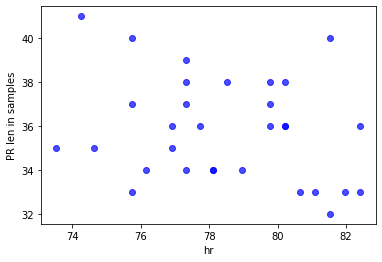

In [ ]:
plt.scatter(X, y, alpha=0.7, color="b")
plt.ylabel("PR len in samples")
plt.xlabel("hr")

In [ ]:
X = np.array(X).reshape(-1,1)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor(n_estimators=200, random_state=100)
model_rf.fit(X, y)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
y_pred = model_rf.predict(X)
mean_squared_error(y, y_pred, squared=False)

In [ ]:
r2_score(y, y_pred)

# Evaluatind regression model on detection

In [ ]:
def rr_pt_detection(signal, model, alpha=0, beta=0, coef=1):
  pt_peaks = []
  out = ecg.ecg(signal=signal, sampling_rate=250., show=False)
  hr = out["heart_rate"]
  mean_hr = np.mean(hr)
  r_peaks = out["rpeaks"]

  for i in range(len(hr)-1):
    coef = hr[i] / mean_hr
    p_min = -20
    p_max = int((-40 - model.predict(np.array(hr[i]).reshape(-1,1))) * coef)
    t_min = 20
    t_max = int((50 + alpha) * coef)

    if i == 0 and r_peaks[i] + p_max >= 0 :
      p_min = -20
      p_max = (-40 - model.predict(np.array(mean_hr).reshape(-1,1)))
      p_signal_slice = signal[int(r_peaks[i] + p_max):int(r_peaks[i] + p_min)]
      if len(p_signal_slice) > 1:
        p_peak = np.argmax(p_signal_slice, axis=0) + r_peaks[i] + p_max
        pt_peaks.append(int(p_peak))

    p_signal_slice = signal[int(r_peaks[i+1] + p_max):int(r_peaks[i+1] + p_min)]
    if len(p_signal_slice) > 1:
      p_peak = np.argmax(p_signal_slice, axis=0) + r_peaks[i+1] + p_max
      pt_peaks.append(int(p_peak))
    t_signal_slice = signal[int(r_peaks[i]+t_min):int(r_peaks[i]+t_max)]
    if len(t_signal_slice) > 1:
      t_peak = np.argmax(t_signal_slice, axis=0) + r_peaks[i] + t_min
      pt_peaks.append(int(t_peak))

  t_min = 20
  t_max = (50 + alpha)
  if r_peaks[len(r_peaks)-1] + t_max <= len(signal):
    t_signal_slice = signal[int(r_peaks[len(r_peaks)-1]+t_min):int(r_peaks[len(r_peaks)-1]+t_max)]
    t_peak = np.argmax(t_signal_slice, axis=0) + r_peaks[len(r_peaks)-1] + t_min
    pt_peaks.append(t_peak)

  pt_peaks.extend(list(r_peaks))
  return sorted(pt_peaks)

In [ ]:
alpha_list = np.arange(-5,40,1)
beta_list = np.arange(-15,50,1)

peaks_p_all = []
peaks_n_all = []
peaks_t_all = []

peaks_p_window_ab_pred_all = []
peaks_n_window_ab_pred_all = []
peaks_t_window_ab_pred_all = []

true_peaks_all = []
true_peaks_all_window_ab_pred = []

for temp_file_index, temp_file in enumerate(input_files):
  print(temp_file_index,"/", len(input_files))
  temp_file_path = os.path.join(input_directory, temp_file)
  record_atr = wfdb.rdann(temp_file_path, 'q1c')
  record = wfdb.rdrecord(temp_file_path, channels=[0])

  l_range = 0
  r_range = len(record.p_signal)+1
  data_slice = np.ndarray.flatten(record.p_signal[l_range:r_range])

  true_peaks, true_symbols = dataset_prep(record_atr.symbol, record_atr.sample)

  mae_t = []

  if len(true_peaks) > 3:
    l_range = 0
    r_range = len(record.p_signal)+1

    data_slice = np.ndarray.flatten(record.p_signal[l_range:r_range])
    for index, alpha in enumerate(alpha_list):
      true_peaks, true_symbols = dataset_prep(record_atr.symbol, record_atr.sample)
      peaks = pqrst_detection(data_slice,qs_drop=True, alpha=alpha)
      true_peaks, peaks = sync_peaks(peaks, true_peaks)
      peaks_t = [val for i,val in enumerate(true_peaks) if (i-2)%3 == 0]

      window_peaks_t = [val for i,val in enumerate(peaks) if (i-2)%3 == 0]
      if len(window_peaks_t) > 1:
        mae_t.append(mean_absolute_error(peaks_t, window_peaks_t))
      else: mae_t.append(9999999)

    alpha = alpha_list[np.argmin(mae_t)]

    l_range = 0
    r_range = len(record.p_signal)+1

    data_slice = np.ndarray.flatten(record.p_signal[l_range:r_range])
    prt_peaks = rr_pt_detection(data_slice,model=model_rf, alpha=alpha, beta=0)

    true_peaks, true_symbols = dataset_prep(record_atr.symbol, record_atr.sample)

    true_peaks, peaks = sync_peaks(prt_peaks, true_peaks)
    true_peaks_all_window_ab_pred.extend(peaks)
    true_peaks_all.extend(true_peaks)

    peaks_p = [val for i,val in enumerate(true_peaks) if i%3 == 0]
    peaks_p_all.extend(peaks_p)
    peaks_n = [val for i,val in enumerate(true_peaks) if (i-1)%3 == 0]
    peaks_n_all.extend(peaks_n)
    peaks_t = [val for i,val in enumerate(true_peaks) if (i-2)%3 == 0]
    peaks_t_all.extend(peaks_t)

    window_peaks_p = [val for i,val in enumerate(peaks) if i%3 == 0]
    peaks_p_window_ab_pred_all.extend(window_peaks_p)
    window_peaks_n = [val for i,val in enumerate(peaks) if (i-1)%3 == 0]
    peaks_n_window_ab_pred_all.extend(window_peaks_n)
    window_peaks_t = [val for i,val in enumerate(peaks) if (i-2)%3 == 0]
    peaks_t_window_ab_pred_all.extend(window_peaks_t)

In [ ]:
print(f"MAE score for window method with a/b and coef:  {mean_absolute_error(true_peaks_all, true_peaks_all_window_ab_pred)}")
print(f"MAE score for window method with a/b and coef p peaks:  {mean_absolute_error(peaks_p_all, peaks_p_window_ab_pred_all)}")
print(f"MAE score for window method with a/b and coef r peaks:  {mean_absolute_error(peaks_n_all, peaks_n_window_ab_pred_all)}")
print(f"MAE score for window method with a/b and coef t peaks:  {mean_absolute_error(peaks_t_all, peaks_t_window_ab_pred_all)}")